<a href="https://colab.research.google.com/github/asu-trans-ai-lab/QVDF/blob/main/PAQ_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before reading the code:

This jupyter notebook shows how to calibrate and plot figures for Polynomial Arrival Queue (PAQ) and Queueing-based Volume-Delay Function (QVDF). You should read the following papers.

Paper information:  

(Paper of PAQ)  
[Qixiu Cheng, Zhiyuan Liu, Jifu Guo, Xin Wu, Ram Pendyala, Baloka Belezamo, Xuesong (Simon) Zhou, Estimating key traffic state parameters through parsimonious spatial queue models, Transportation Research Part C: Emerging Technologies, Volume 137,
2022, 103596,](https://www.sciencedirect.com/science/article/pii/S0968090X22000420)

(Paper of QVDF)  
[Xuesong Simon Zhou, Qixiu Cheng, Xin Wu, Peiheng Li, Baloka Belezamo, Jiawei Lu, Mohammad Abbasi, A meso-to-macro cross-resolution performance approach for connecting polynomial arrival queue model to volume-delay function with inflow demand-to-capacity ratio,
Multimodal Transportation,
Volume 1, Issue 2,
2022,
100017,](https://www.sciencedirect.com/science/article/pii/S277258632200017X)

(Paper of S-shaped three-parameter fundamental diagram, S3 model)  
[Qixiu Cheng, Zhiyuan Liu, Yuqian Lin, Xuesong (Simon) Zhou, An s-shaped three-parameter (S3) traffic stream model with consistent car following relationship, Transportation Research Part B: Methodological, Volume 153, 2021, Pages 246-271](https://www.sciencedirect.com/science/article/pii/S0191261521001715)



### load necessary package

In [13]:
import numpy as np
from math import sqrt
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### Configure parameters for matplotlib.pyplot

In [14]:
plt.rc('font',family='Times New Roman')

### Define a class for Polynomial Arrival Queue (PAQ)

#### Equations used in the class  

Eq.1:
\begin{equation}
 Q(t) = \gamma(t-t_0)^2\left[\frac{1}{4}(t-t_0)^2-\frac{1}{3}(t-t_0)(t_3-t_0)(m+\frac{3-4m}{4-6m})+\frac{1}{2}\cdot\frac{(3-4m)m}{(4-6m)}(t_3-t_0)^2\right]
\end{equation}

$Q(t)$: bottleneck's virtual queue length at time $t$  
$\gamma$: curvature parameter  
$t_0$: start time of congestion  
$t_3$: end time of congestion  
$m$: oversaturation parameter  
$t$: time instant at which the vehicle arrives at the bottleneck  

Eq.2:
\begin{equation}
Q^p(t')=Q(t)\cdot\frac{1}{1-\frac{v_{\mu}}{v_f}}
\end{equation}

$Q^p(t')$: bottleneck's physical queue length for vehicle encountering the congestion at time $t'$  
$Q(t)$: bottleneck's virtual queue length at time $t$  
$v_f$: free-flow speed  
$v_{\mu}$: speed at capacity (cut-off speed) 

Eq.3:
\begin{equation}
\lambda(t)=\gamma\cdot(t-t_0)(t-t_2)(t-\bar t)+\mu
\end{equation}

$t_0$: start time of congestion  
$t_2$: time with lowest speed, it is also the time instant with the maximum queue length  
$\bar t$: another root besides for $t_0$ and $t_2$ of the cubic net flow rate function $(\lambda(t)-\mu)$   
$\lambda(t)$: arrival rate function at time $t$  
$\mu$: discharge rate, assumed to be a constant value  
$\gamma$: shape paramter for the cubic arrival rate function  

Eq.4:
\begin{equation}
t_2=t_0+m\cdot(t_3-t_0)
\end{equation}
$t_0$: start time of congestion  
$t_2$: time with lowest speed, it is also the time instant with the maximum queue length  
$t_3$: end time of congestion  
$m$: oversaturation parameter

Eq.5:
\begin{equation}
\bar t=t_0+(3-4m)\cdot\frac{t_3-t_0}{4-6m}
\end{equation}
$\bar t$: another root besides for $t_0$ and $t_2$ of the cubic net flow rate function $(\lambda(t)-\mu)$   
$t_0$: start time of congestion  
$t_3$: end time of congestion  
$m$: oversaturation parameter

In [44]:
class PAQ:
    
    def __init__(self, t0, t3, v_f, mu, v_mu, start_time_index, end_time_index):
        self.t0 = t0
        self.t3 = t3
        self.v_f = v_f
        self.mu = mu
        self.v_mu = v_mu
        self.P = t3 - t0
        self.start_time_index = start_time_index
        self.end_time_index = end_time_index
        self.t = np.linspace(t0, t3, num=100)
        self.factor_virQueue2phyQueue=1-self.v_mu/self.v_f
        
    def get_virtual_queue(self, gamma, m):
        virtual_queue = np.zeros(len(self.t))
        for i in range(len(self.t)):
            virtual_queue[i] = gamma*(self.t[i] - self.t0)**2*(0.25*(self.t[i] - self.t0)**2 
                                - 1/3*((3-4*m)/(4-6*m)+m)*(self.t3 - self.t0)*(self.t[i] - self.t0) 
                                + 1/2*(3 - 4*m)*m/(4 - 6*m)*((self.t3 - self.t0)**2))#eq.1
        return virtual_queue
    
    def get_physical_queue(self,gamma, m):
        physical_queue = np.zeros(len(self.t))
        virtual_queue=self.get_virtual_queue(gamma, m)
        for i in range(len(self.t)):
            physical_queue[i] = 1/self.factor_virQueue2phyQueue*virtual_queue[i]#eq.2
        return physical_queue
    
    def cubic_model_Q(self, x, obsQueue):
        gamma = x[0]
        m = x[1]
        # initialization
        Q_t = np.zeros(len(self.obsQueue))
        
        virtual_queue = get_virtual_queue(self,gamma,m)
        
        for i in range(len(self.obsCumulativeDeparture)):
            Q_t[i] = 1/self.factor_virQueue2phyQueue*virtual_queue[i]#eq.2
        obj_fun = np.sum((Q_t - obsQueue)**2)
        return obj_fun
    
    def constraint1(self, x):
        gamma = x[0]
        m = x[1]
        t2 = self.t0 + m*(self.t3 - self.t0)
        t_bar = self.t0 + (3 - 4*m)*(self.t3 - self.t0)/(4 - 6*m)#eq.5
        inflow_rate = gamma*(self.t - self.t0)*(self.t - t2)*(self.t - t_bar) + self.mu#eq.3
        return inflow_rate
    
    def bounds(self):
        bounds = np.asarray([[1, 20], [0.5, 0.666]])  # lower and upper bounds for gamma and m
        return bounds
    
    def initial_value(self):
        x0 = np.asarray([10.0, 0.58])
        return x0
    
    def calibration_with_newton(self):
        x0 = self.initial_value()
        solution = minimize(self.cubic_model_Q, x0, method='Newton-CG', jac = self.Z_first_order_derivative, hess = self.Z_second_order_derivative, 
                            options={'maxiter': 1000, 'xtol': 1e-12, 'eps': 1e-12, 'disp': False})
        gamma, m = solution.x
        obj = solution.fun
        return gamma, m, obj
    
      
    def plot_InflowRate(self, mu, gamma, m, lane_capacity):
        fig = plt.figure()
        inflow_rate = gamma*(self.t - self.t0)*(self.t - self.t0 - m*(self.t3 - self.t0))*(self.t - self.t0 - (3-4*m)*(self.t3 - self.t0)/(4 - 6*m)) + mu
        plt.plot(self.t, inflow_rate, 'r-', linewidth=3, label = 'Inflow rate')
        plt.hlines(mu, self.t0, self.t3, colors = 'b', linestyles = 'dashed', linewidth=2, label = '$\mu$')
        plt.hlines(lane_capacity, self.t0, self.t3, colors = 'b', linewidth=2, label = 'cap')
        plt.xticks([13+i for i in range(0,8)], 
                    labels=['13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00'], fontsize=10)
        plt.ylabel('Number of vehicles (per hour per lane)', fontsize=12)
        plt.xlabel('Time', fontsize=12)
        plt.ylim((500, 1300))
        plt.legend(loc=0)
        plt.title('PAQ: Arrival rate and $\mu$', fontsize=16)
#        fig.savefig('../Figures/Case 1/Inflow rate.png', dpi=300, bbox_inches='tight')
    
    def plot_QueueLength(self, mu, gamma, m):
        # Plot queue length
        fig = plt.figure()
        calQueue = self.get_virtual_queue(gamma,m)
        physical_queue = self.get_physical_queue(gamma, m)
#        plt.scatter(self.t, calQueue, s = 2, marker='Q', c='b', edgecolors='b', label='queue')
        plt.plot(self.t, calQueue, 'r-', linewidth=3, label = 'virtual queue length')
        plt.plot(self.t, physical_queue, 'b-', linewidth=3, label = 'physical queue length')
        plt.xticks([13+i for i in range(0,8)], 
                    labels=['13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00'], fontsize=10)
        plt.ylabel('Number of vehicles', fontsize=12)
        plt.xlabel('Time', fontsize=12)
        plt.ylim((0, 1500))
        plt.legend(loc=2)
        plt.title('PAQ: queue length', fontsize=16)
#        fig.savefig('../Figures/Case 1/Calibration of queue.png', dpi=300, bbox_inches='tight')
        



### Define a class for Queueing-based Volume-Delay Function (QVDF)

#### Equations used in the class 

In [36]:
class QVDF:
    def __init__(self, V, L, plf, C, t2, Q_cd, Q_n):
        self.V = V
        self.L = L
        self.plf = plf
        self.D = 0
        self.C = C
        self.t2 = t2
        self.Q_cd = Q_cd
        self.Q_n = Q_n
     
    def get_mu(self, P):
        return min(self.D/P, self.C)
    
    def get_P(self):
        self.D = self.V/self.L/self.plf
        DOC = self.D/self.C
        P = self.Q_cd * pow(DOC, self.Q_n);  # applied for both uncongested and congested conditions
        return P

### Configure parameters of PAQ and QVDF, and plot figures

$t_0$: start time of congestion, in this example, it is 13:10  
$t_3$: end time of congestion, in this example, it is 19:45  
$t_2$: time instant with the lowest speed and the maximum queue length, in this example, it is the middle point between 13:10 and 19:45  
$\mu$: discharge rate, in this example, it is 1000 veh / hour  
$Q_{cd}$: elasticity in equation linking congestion duration and inflow demand-to-capacity ratio  
$Q_n$: elasticity in equation linking congestion duration and inflow demand-to-capacity ratio  
$C$: lane-based hourly ultimate capacity, in this example, it is 1000 veh/lane/hour  
$v_f$: free-flow speed, in this example, it is 53 mile/hour  
$v_{\mu}$: speed at capacity (cut-off speed), in this example, it is 25 mile/hour  
$\gamma$: curvature parameter, in this example, it is 10  
$m$: oversaturation parameter, in this example, it is 0.58  
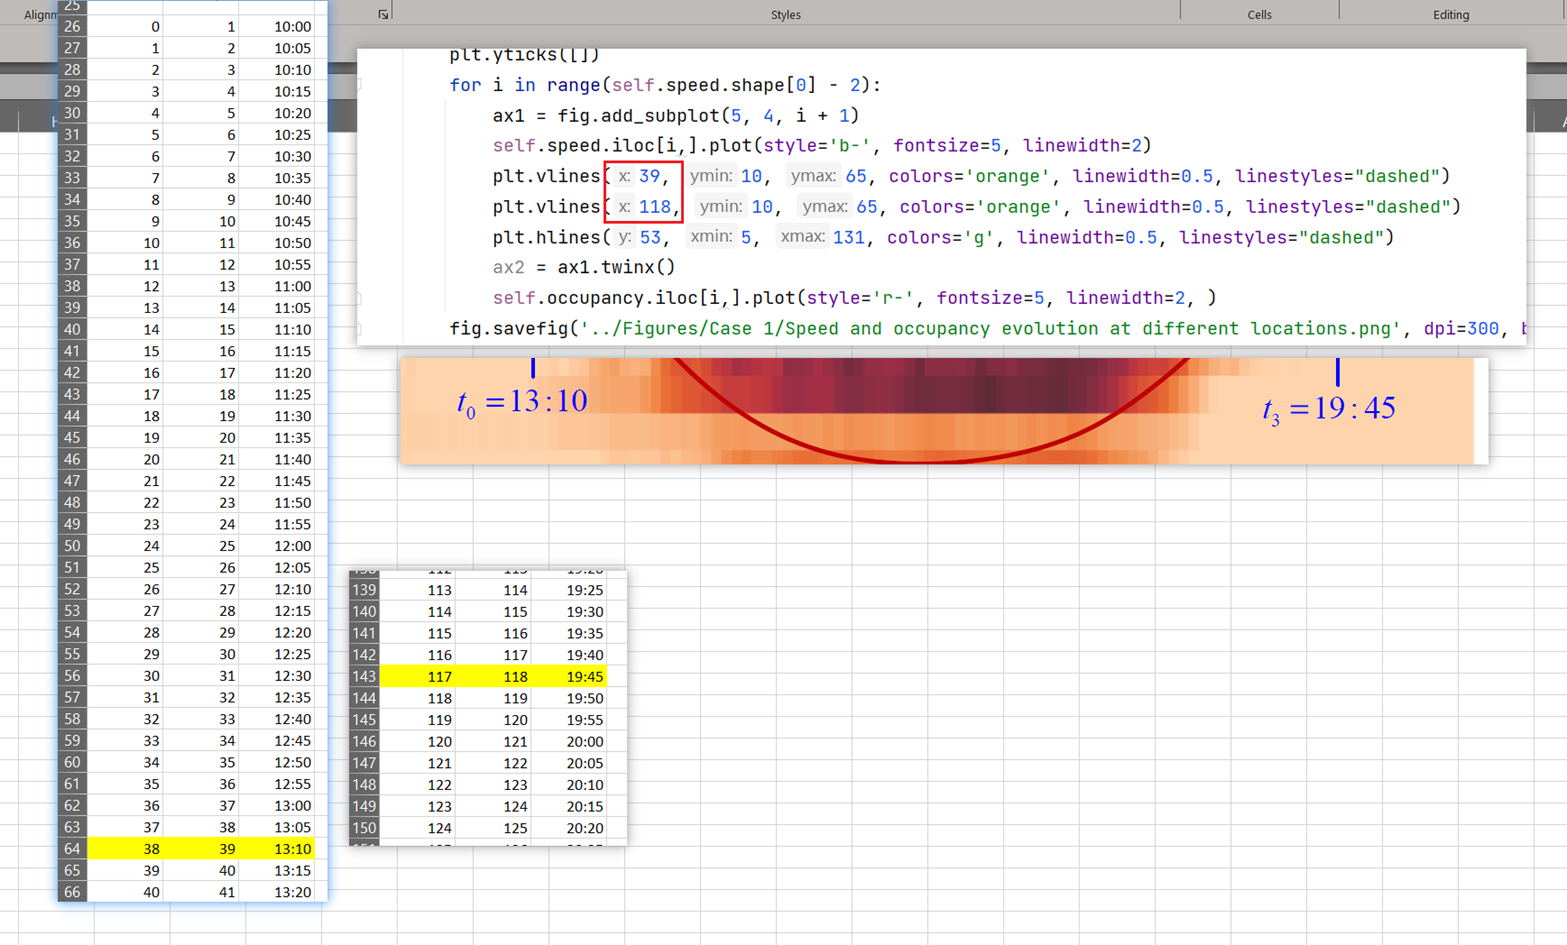

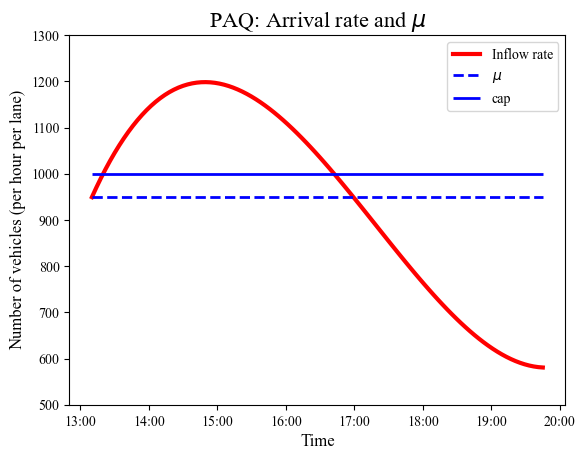

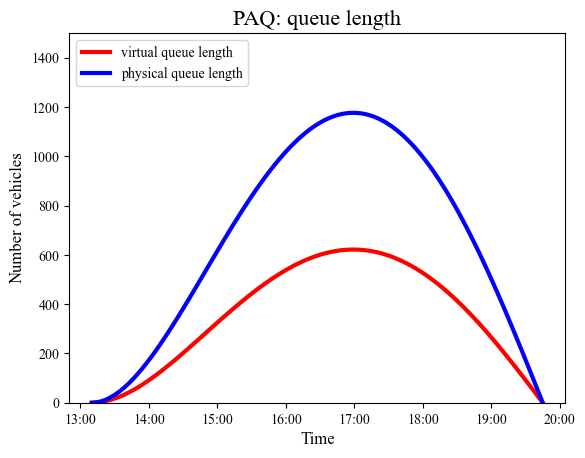

In [45]:
if __name__ == '__main__':
    
    t2 = 10 + (38+117)/2 
    mu = 1000
    Q_cd = 0.954946463
    Q_n = 1.141574427
    lane_capacity = 1000
    qvdf0 = QVDF(V=2000, L=1, plf=1, C=lane_capacity, t2=t2, Q_cd=Q_cd, Q_n=Q_n)
    
    P = qvdf0.get_P()
    mu = qvdf0.get_mu(P)
    
    t0 = 10+38/12   # t0=13:10:00, 
    t3 = 10+117/12  # t3=19:44:59
    v_f = 53        
    v_mu = 25       
    start_time_index = 38       
    end_time_index = 117       

    paq0 = PAQ(t0, t3, v_f, mu, v_mu, start_time_index, end_time_index)
    gamma = 10.0 
    m = 0.58
    paq0.plot_InflowRate(mu, gamma, m, lane_capacity)
    paq0.plot_QueueLength(mu, gamma, m)